In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchinfo import summary
from tqdm import notebook


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

# Dataset

In [2]:
BATCH_SIZE = 256

with np.load('D:/Datasets/mnist.npz') as mnist:
    x_train, y_train, x_test, y_test = mnist['x_train'], mnist['y_train'], mnist['x_test'], mnist['y_test']

dataloader = torch.utils.data.DataLoader([*zip(x_train, y_train)], batch_size=BATCH_SIZE, shuffle=True)

# Models

In [2]:
H_DIM = 64
LEAKY = 0.1  # LeakyReLU coefficient

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(28 * 28 + 10, 256),
            # nn.BatchNorm1d(256),  # Makes things worse
            nn.LeakyReLU(LEAKY),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x, lables):
        lables = F.one_hot(lables.long(), num_classes=10)
        x = torch.cat([x, lables], dim=-1)
        return self.disc(x)
    
discriminator = Discriminator().to(DEVICE)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-3)

# print(summary(discriminator, ((2, 28*28), [2]), device=DEVICE))

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(H_DIM + 10, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(LEAKY),
            nn.Linear(256, 28 * 28),
            nn.Tanh(),
        )
        
    def forward(self, x, lables):
        lables = F.one_hot(lables.long(), num_classes=10)
        x = torch.cat([x, lables], dim=-1)
        return self.gen(x)
    
generator = Generator().to(DEVICE)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=3e-3)

# print(summary(generator, ((2, H_DIM), [2]), device=DEVICE))

In [ ]:
# GET DISCRIMINATOR LR

for pg in optimizer_d.param_groups:
    print(pg['lr'])

0.01


In [25]:
# CHANGE DISCRIMINATOR LR

for pg in optimizer_d.param_groups:
    pg['lr'] = 1e-3

In [ ]:
# GET GENERATOR LR

for pg in optimizer_g.param_groups:
    print(pg['lr'])

3e-05


In [26]:
# CHANGE GENERATOR LR

for pg in optimizer_g.param_groups:
    pg['lr'] = 1e-3

# Tensorboard

In [6]:
tb = SummaryWriter('runs/FC-CGAN_MNIST/fake')

In [82]:
tb.close()

# Training

In [7]:
step = 1

In [10]:
FIXED_NOISE = torch.randn(24, H_DIM).to(DEVICE)  # hidden points for samples
# FIXED_LBLS = torch.randint(0, 10, size=(FIXED_NOISE.shape[0],)).to(DEVICE)
FIXED_LBLS = torch.tensor([0,0, 1,1, 2,2,2, 3,3,3, 4,4,4, 5,5,5, 6,6, 7,7, 8,8, 9,9], device=DEVICE)

In [ ]:
EPOCHS = 100
MONITORING_INTERVAL = 2  # epoch interval to save result images eamples
SAVE_INTERVAL = 0  # save model weights and optimizer state every SAVE_INTERVAL epoch; use 0 for no save

for epoch in range(EPOCHS):
    pbar = notebook.tqdm(dataloader)
    for batch_idx, (x_real, lbl) in enumerate(pbar):
        pbar.set_description(f'EPOCHE={epoch + 1}')

        x_real = x_real / 255.
        x_real = x_real * 2 - 1
        x_real = x_real.view(-1, 28 * 28).to(DEVICE, dtype=torch.float)
        lbl = lbl.to(DEVICE)
        
        batch_size = x_real.shape[0]
        noise = torch.randn((batch_size, H_DIM)).to(DEVICE)
        
        ## DISCRIMINATOR
        discriminator.train()
        generator.eval()
        fake = generator(noise, lbl)

        discriminator_real = discriminator(x_real, lbl).view(-1)
        discriminator_fake = discriminator(fake, lbl).view(-1)
        loss_d_real = nn.BCELoss()(discriminator_real, torch.ones_like(discriminator_real))
        loss_d_fake = nn.BCELoss()(discriminator_fake, torch.zeros_like(discriminator_fake))
        loss_d = (loss_d_real + loss_d_fake) / 2
        discriminator.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        
        accuracy_d = accuracy_score(torch.cat([discriminator_real, discriminator_fake], dim=0).detach().round().to('cpu'), 
                                    torch.cat([torch.ones_like(discriminator_real), torch.zeros_like(discriminator_fake)], dim=0).detach().round().to('cpu'))
        
        ## GENERATOR
        discriminator.eval()
        generator.train()
        fake = generator(noise, lbl)
        
        output = discriminator(fake, lbl).view(-1)
        loss_g = nn.BCELoss()(output, torch.ones_like(output))
        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        
        ## MONITORING
        pbar.set_postfix({'accuracy_d->': accuracy_d, 'loss_d->': float(loss_d), 'loss_g->': float(loss_g), 'step->': str(step)})
        
        step += 1


    ## SAVE IMAGES EXAMPLES
    if MONITORING_INTERVAL and not epoch % MONITORING_INTERVAL:
        generator.eval()
        with torch.no_grad():
            tb.add_images('CGAN FAKE', ((generator(FIXED_NOISE, FIXED_LBLS) + 1) / 2).detach().view(-1, 1, 28, 28), global_step=step - 1)

    ## SAVE MODEL WEIGHTS AND OPTIMIZER STATE
    if SAVE_INTERVAL and not epoch % SAVE_INTERVAL:
        torch.save({
            'discriminator': discriminator.state_dict(), 
            'optimizer_d': optimizer_d.state_dict(),
            'generator': generator.state_dict(), 
            'optimizer_g': optimizer_g.state_dict(),
            }, f'checkpoints/weights_FC-CGAN-MNIST-hdim{H_DIM}-step{step - 1}.pth')

In [7]:
## LOAD

params = torch.load('checkpoints/_weights_FC-CGAN-MNIST-hdim64-step94676.pth', map_location=DEVICE)

discriminator.load_state_dict(params['discriminator'])
generator.load_state_dict(params['generator'])
optimizer_d.load_state_dict(params['optimizer_d'])
optimizer_g.load_state_dict(params['optimizer_g'])

# Let's Play!

In [8]:
generator.eval();

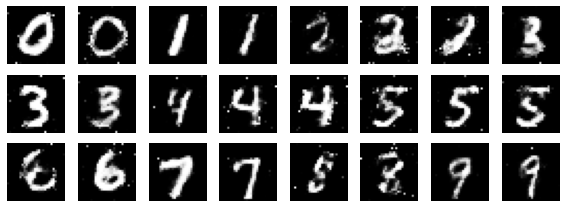

In [11]:
## Plot random examples

fig, axs = plt.subplots(3, 8, figsize=(8, 3))
with torch.no_grad():
    for ax, fake_i in zip(axs.ravel(), (generator(FIXED_NOISE, FIXED_LBLS).detach().to('cpu') + 1) / 2):
        ax.imshow(fake_i.clip(0, 1).view(28,28,-1), cmap='gray')
        ax.axis('off')
plt.tight_layout()

In [26]:
def plot_digit_variants(digit: int):
    """Plots variants of digit generated with CGAN from different hidden space points."""
    fig, axs = plt.subplots(3, 8, figsize=(8, 3))
    with torch.no_grad():
        for ax, fake_i in zip(axs.ravel(), (generator(FIXED_NOISE, torch.tensor([digit] * FIXED_NOISE.shape[0], dtype=torch.long, device=DEVICE)).detach().to('cpu') + 1) / 2):
            ax.imshow(fake_i.clip(0, 1).view(28, 28, -1), cmap='gray')
            ax.axis('off')
    plt.tight_layout()

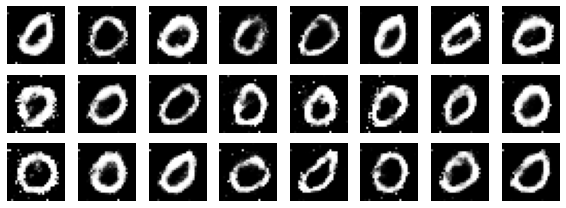

In [27]:
plot_digit_variants(0)

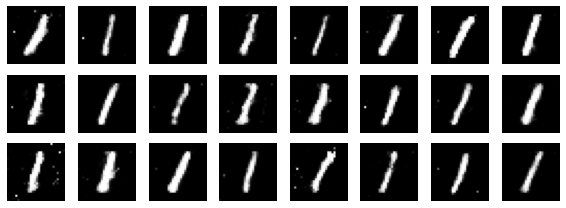

In [28]:
plot_digit_variants(1)

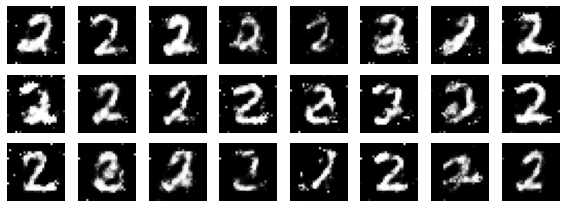

In [29]:
plot_digit_variants(2)

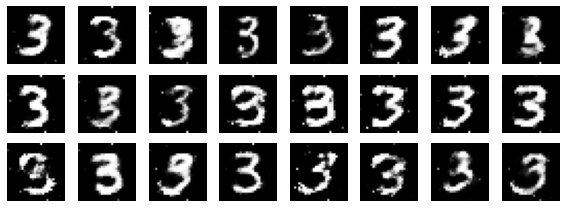

In [30]:
plot_digit_variants(3)

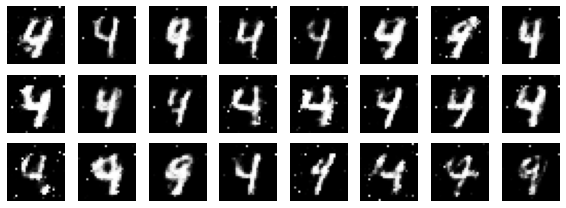

In [31]:
plot_digit_variants(4)

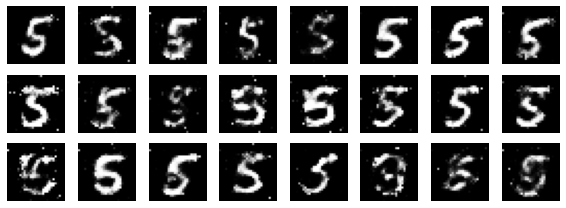

In [32]:
plot_digit_variants(5)

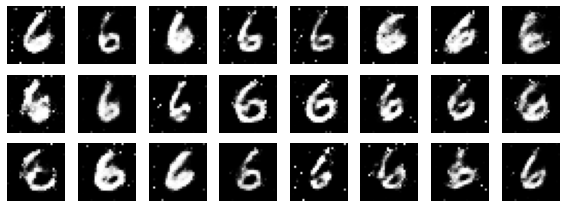

In [33]:
plot_digit_variants(6)

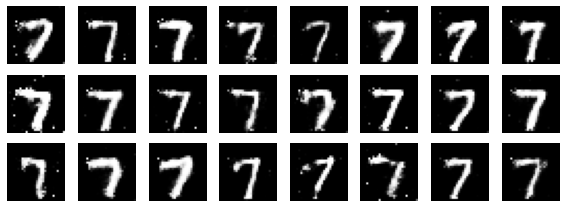

In [34]:
plot_digit_variants(7)

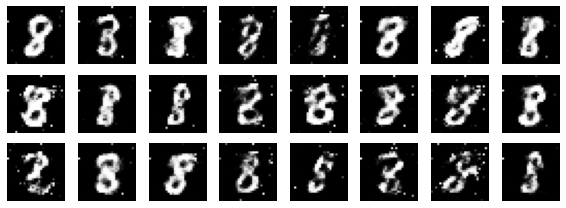

In [35]:
plot_digit_variants(8)

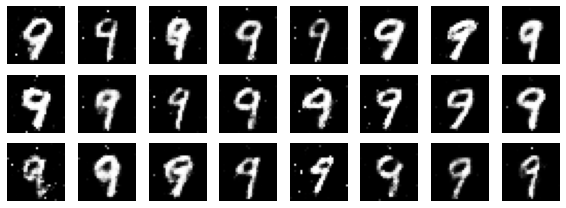

In [36]:
plot_digit_variants(9)